In [1]:
#Run 2022 and 2023
import pandas as pd
import numpy as np
import os
from pipeline_utils import _read_bytes_image
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.io import fits
import gzip
import io
from matplotlib.gridspec import GridSpec

In [2]:
import matplotlib

colors={"orange":"#ED9145",
        "dark_brown":"#473832",
        "beige":"#E2D3C1",
        "rose":"#BC7E74",
        "dark_blue":"#21609D",
        "light_blue":"#5C92C1",
        "dark_gray":"#4D5966",
        "black":"#27242A",
        "light_gray":"#8999A1",
        "golden_brown":"#87581D"}

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [colors['dark_blue'],
                                                                colors['orange']])

In [33]:
#Initial number of alerts
parquet_files_list_path_2y= "/media3/CRP7/hosts/data/final/SIMBAD_not_in_MANGROVE_with_candidates_2022_2023/"
origi_files2y = os.listdir(parquet_files_list_path_2y)
len(origi_files2y)
events2y = []
events2y_with_one_stamp = []
for of2y in origi_files2y:
    try:
        dfof2y = pd.read_parquet(parquet_files_list_path_2y+of2y)
        events2y.append(list(dfof2y['objectId']))
        for obj in range(len(dfof2y['objectId'])):
            if len(dfof2y['i:fwhm'][obj]) <= 1:
                #print(dfof2y['objectId'][obj])
                events2y_with_one_stamp.append(dfof2y['objectId'][obj])
    except:
        print(of2y)
events2y = sum(events2y,[])
print('Initial number of events: ',len(np.unique(np.array(events2y))))
print('Events with only one stamp: ',len(events2y_with_one_stamp))

_SUCCESS
Initial number of events:  155623
Events with only one stamp:  62983


In [3]:
result_files = os.listdir()
result_files = [i for i in result_files if 'final_results' in i]
len(result_files)

200

In [4]:
monster_df = pd.DataFrame()
for rs in result_files:
    dfrf = pd.read_parquet(rs)
    monster_df = pd.concat([monster_df, dfrf])
monster_df = monster_df.reset_index(drop=True)

In [5]:
#Drop objects with catalog association
idxs_with_catalog_associations = []
for i in range(len(monster_df)):
    if len(np.unique(monster_df['gcvs'][i])) != 1 or len(np.unique(monster_df['3hsp'][i])) != 1 or len(np.unique(monster_df['4lac'][i])) != 1:
        idxs_with_catalog_associations.append(i)
    elif len(np.unique(monster_df['gcvs'][i])) == 1 and np.unique(monster_df['gcvs'][i]) != 'Unknown' or  \
         len(np.unique(monster_df['3hsp'][i])) == 1 and np.unique(monster_df['3hsp'][i]) != 'Unknown' or \
         len(np.unique(monster_df['4lac'][i])) == 1 and np.unique(monster_df['4lac'][i]) != 'Unknown':
        idxs_with_catalog_associations.append(i)
        
monster_df = monster_df.drop(idxs_with_catalog_associations)
monster_df = monster_df.reset_index(drop=True)

In [6]:
unique_tns_class = []
for i in range(len(monster_df['v:tns_classification'])):
    if np.unique(monster_df['v:tns_classification'][i])[0] == 'Unknown':
        unique_tns_class.append(np.unique(monster_df['v:tns_classification'][i])[0])
    else:
        unique_tns_class.append((np.unique(monster_df['v:tns_classification'][i])[0].split(')'))[1])
monster_df['unique_tns_class'] = unique_tns_class

In [10]:
print('Events after removing cropped and single stamps: ',len(monster_df))
print('Events with bad stamps: ',len(np.unique(np.array(events2y)))-len(events2y_with_one_stamp)-len(monster_df))

Events after removing cropped and single stamps:  90928


NameError: name 'events2y' is not defined

In [11]:
#Add a column with class probability based on the classes associated to the stamps
monster_df.columns

Index(['i:aimage', 'i:aimagerat', 'i:bimage', 'i:bimagerat', 'i:candid',
       'i:chinr', 'i:chipsf', 'i:classtar', 'i:dec', 'i:fid', 'i:fwhm',
       'i:isdiffpos', 'i:jd', 'i:maggaia', 'i:maggaiabright', 'i:magpsf',
       'i:neargaia', 'i:neargaiabright', 'i:ra', 'i:sigmapsf', 'cdsxmatch',
       'roid', 'mulens', 'snn_snia_vs_nonia', 'snn_sn_vs_all',
       'rf_snia_vs_nonia', 'ndethist', 'drb', 'classtar', 'jd', 'jdstarthist',
       'rf_kn_vs_nonkn', 'v:classification', 'v:tns_classification',
       'mangrove', 'gcvs', 'vsx', '3hsp', '4lac', 'objectId',
       'b:cutoutScience_stampData', 'b:cutoutTemplate_stampData',
       'b:cutoutDifference_stampData', 'b:cutoutScience_stampData_stacked',
       'b:cutoutTemplate_stampData_stacked',
       'b:cutoutDifference_stampData_stacked', 'science_clipped',
       'template_clipped', 'number_of_stamps_in_stacking',
       'is_hostless_candidate_clipping', 'distance_science',
       'distance_template', 'unique_tns_class'],
      dtyp

In [12]:
c = 0
for i in range(len(monster_df['objectId'])):
    if len(monster_df['i:fwhm'][i])>=1 and monster_df['number_of_stamps_in_stacking'][i] == 1:
        c+=1
print('Events with more than one observation but only 1 stamp in the best FWHM bin: ',c)

Events with more than one observation but only 1 stamp in the best FWHM bin:  15713


In [13]:
#Hostless events
hostless = monster_df[monster_df['is_hostless_candidate_clipping']]
hostless = hostless.reset_index(drop=True)
print('Number of hostless candidates: ',len(hostless))

Number of hostless candidates:  1669


In [14]:
#Add PS statistic for the 15pix science stamp
ps_path = '/media3/ppessi/extragalactic_hostless/src/save_folder/ps_results/'
#KS
ps_ks_template_15_statistic = []
for i in range(len(hostless)):
    ks = pd.read_csv(ps_path+hostless['objectId'][i]+'_kstest.csv')
    idxtemp = np.where(ks['IMAGE_TYPE']=='TEMPLATE')[0]
    kstemp  = ks.iloc[idxtemp]
    kstemp  = kstemp.reset_index(drop=True)
    idxtemp15pix   = np.where(kstemp['CUTOUT_SIZE']==15)[0][0]
    ks_15_tempstat = kstemp['STATISTIC'][idxtemp15pix]
    ps_ks_template_15_statistic.append(ks_15_tempstat)

ps_ks_science_15_statistic = []
for i in range(len(hostless)):
    ks = pd.read_csv(ps_path+hostless['objectId'][i]+'_kstest.csv')
    idxsci = np.where(ks['IMAGE_TYPE']=='SCIENCE')[0]
    kssci  = ks.iloc[idxsci]
    kssci  = kssci.reset_index(drop=True)
    idxsci15pix   = np.where(kssci['CUTOUT_SIZE']==15)[0][0]
    ks_15_scistat = kssci['STATISTIC'][idxsci15pix]
    ps_ks_science_15_statistic.append(ks_15_scistat)

hostless['ps_ks_template_15_statistic'] = ps_ks_template_15_statistic
hostless['ps_ks_science_15_statistic'] = ps_ks_science_15_statistic

In [40]:
hostless.columns

Index(['i:aimage', 'i:aimagerat', 'i:bimage', 'i:bimagerat', 'i:candid',
       'i:chinr', 'i:chipsf', 'i:classtar', 'i:dec', 'i:fid', 'i:fwhm',
       'i:isdiffpos', 'i:jd', 'i:maggaia', 'i:maggaiabright', 'i:magpsf',
       'i:neargaia', 'i:neargaiabright', 'i:ra', 'i:sigmapsf', 'cdsxmatch',
       'roid', 'mulens', 'snn_snia_vs_nonia', 'snn_sn_vs_all',
       'rf_snia_vs_nonia', 'ndethist', 'drb', 'classtar', 'jd', 'jdstarthist',
       'rf_kn_vs_nonkn', 'v:classification', 'v:tns_classification',
       'mangrove', 'gcvs', 'vsx', '3hsp', '4lac', 'objectId',
       'b:cutoutScience_stampData', 'b:cutoutTemplate_stampData',
       'b:cutoutDifference_stampData', 'b:cutoutScience_stampData_stacked',
       'b:cutoutTemplate_stampData_stacked',
       'b:cutoutDifference_stampData_stacked', 'science_clipped',
       'template_clipped', 'number_of_stamps_in_stacking',
       'is_hostless_candidate_clipping', 'distance_science',
       'distance_template', 'unique_tns_class', 'ps_ks_temp

In [15]:
#Hostless events with TNS classification
hostless_tns_class = hostless[hostless['unique_tns_class']!='Unknown']
hostless_tns_class = hostless_tns_class.reset_index(drop=True)
print('Number of hostless candidates with TNS class: ',len(hostless_tns_class))
#Hostless events without TNS classification but with ML class
hostless_ml_class = hostless[hostless['unique_tns_class']=='Unknown']
hostless_ml_class = hostless_ml_class.reset_index(drop=True)
print('Number of hostless candidates with only ML class: ',len(hostless_ml_class))

Number of hostless candidates with TNS class:  181
Number of hostless candidates with only ML class:  1488


In [16]:
#Decide on the final class of ml classifications for things with associated TNS class
unique_ml_tns_class = []
for i in range(len(hostless_tns_class['v:classification'])):
    if len(np.unique(hostless_tns_class['v:classification'][i])) == 1:
        unique_ml_tns_class.append(np.unique(hostless_tns_class['v:classification'][i])[0])
    elif len(np.unique(hostless_tns_class['v:classification'][i])) > 1 and 'Unknown' in np.unique(hostless_tns_class['v:classification'][i]):
        if 'SN' in np.unique(hostless_tns_class['v:classification'][i]) :
            unique_ml_tns_class.append('SN')
        elif 'SN candidate' in np.unique(hostless_tns_class['v:classification'][i]) :
            unique_ml_tns_class.append('SN candidate')
        elif 'SN candidate' not in np.unique(hostless_tns_class['v:classification'][i]) :
            unique_ml_tns_class.append(np.unique(hostless_tns_class['v:classification'][i])[0])
    elif len(np.unique(hostless_tns_class['v:classification'][i])) > 1:
        unique_ml_tns_class.append('SN candidate')
hostless_tns_class['unique_ml_class'] = unique_ml_tns_class

In [17]:
#Decide on the final class of ml classifications
unique_ml_class = []
for i in range(len(hostless_ml_class['v:classification'])):
    if len(np.unique(hostless_ml_class['v:classification'][i])) == 1:
        unique_ml_class.append(np.unique(hostless_ml_class['v:classification'][i])[0])
    elif len(np.unique(hostless_ml_class['v:classification'][i])) > 1 and 'Early SN Ia candidate' in np.unique(hostless_ml_class['v:classification'][i]):
        unique_ml_class.append(np.unique(hostless_ml_class['v:classification'][i])[1])
    elif len(np.unique(hostless_ml_class['v:classification'][i])) > 1 and 'QSO' in np.unique(hostless_ml_class['v:classification'][i]):
        unique_ml_class.append(np.unique(hostless_ml_class['v:classification'][i])[np.where(np.unique(hostless_ml_class['v:classification'][i])!='QSO')[0][0]])
    elif len(np.unique(hostless_ml_class['v:classification'][i])) > 1 and 'Kilonova candidate' in np.unique(hostless_ml_class['v:classification'][i]):
        if max(hostless_ml_class['rf_kn_vs_nonkn'][i]) > max(hostless_ml_class['snn_sn_vs_all'][i]):
            unique_ml_class.append(np.unique(hostless_ml_class['v:classification'][i])[0])
        elif max(hostless_ml_class['rf_kn_vs_nonkn'][i]) < max(hostless_ml_class['snn_sn_vs_all'][i]):            
            unique_ml_class.append(np.unique(hostless_ml_class['v:classification'][i])[1])
hostless_ml_class['unique_ml_class'] = unique_ml_class

In [18]:
tns_with_host=['ZTF23aaxdfya','ZTF22aajhtpy','ZTF22aazmooy','ZTF23aapqkvw','ZTF22abyivoq','ZTF18aatpnrf','ZTF22abtltcw','ZTF22abzakdd',
               'ZTF23aasbvab','ZTF22aauiabm','ZTF18aaxljll','ZTF23aamqonh','ZTF18abvgjyl','ZTF18acdqmxr','ZTF22aboixdd','ZTF23aadefex',
               'ZTF23aawcygl','ZTF18abskoyh','ZTF23aaaairl','ZTF22aakdbia','ZTF23aaajtqn','ZTF18admasii','ZTF23aabtgej','ZTF22abnwvyc',
               'ZTF22aagzbux','ZTF22abdibiz','ZTF23aaiyexs','ZTF22abbausm','ZTF18aczdmti','ZTF22aahebcu','ZTF18aahfqbc','ZTF22abyuoan',
               'ZTF23absbyol','ZTF22aboawxv','ZTF22aanrqje','ZTF18aabqgnb','ZTF18acydvjn','ZTF23abhokcy','ZTF19abszdld','ZTF23aajlkxc',
               'ZTF23aadvjqb','ZTF18abfylqx','ZTF18adnjpdf','ZTF18aaajfsd','ZTF22aboaiim','ZTF22aaolwsd','ZTF18abtgyme','ZTF23aajhtuu',
               'ZTF22aabtyli','ZTF23abaderr','ZTF18absoghh','ZTF19abkaxlf','ZTF22abahblc','ZTF23aaejvzv','ZTF18aczddnw','ZTF18adoeywv',
               'ZTF23aafggjj','ZTF18abjkryl','ZTF18adkgxye','ZTF23aaawcvx','ZTF22abtsypf','ZTF22aadqkgp','ZTF23aajrmfh']

In [19]:
len(tns_with_host)

63

In [20]:
N0 = 0
for i in range(len(hostless_ml_class['objectId'])):
    if hostless_ml_class['ps_ks_template_15_statistic'][i] < 0.5 or hostless_ml_class['ps_ks_science_15_statistic'][i] < 0.5:
        N0+=1
print('Number of ML hostless when considering KS', N0)

N0 = 0
for i in range(len(hostless_tns_class['objectId'])):
    if hostless_tns_class['ps_ks_template_15_statistic'][i] < 0.5 or hostless_tns_class['ps_ks_science_15_statistic'][i] < 0.5 :
        N0+=1
print('Number of TNS hostless when considering KS', N0)

Number of ML hostless when considering KS 1409
Number of TNS hostless when considering KS 154


In [32]:
hostless_tns_class_after_ps = hostless_tns_class[(hostless_tns_class['ps_ks_template_15_statistic'] < 0.5) | (hostless_tns_class['ps_ks_science_15_statistic'] < 0.5)]
hostless_tns_class_after_ps['unique_tns_class'].value_counts()*100/len(hostless_tns_class_after_ps)

unique_tns_class
 SN Ia              61.688312
 SLSN-I             12.987013
 SN IIn              5.844156
 SN II               4.545455
 SN Ic-BL            2.597403
 SN Ia-91T-like      2.597403
 SN Ia-CSM           1.948052
 SN IIb              1.298701
 Nova                1.298701
 Other               1.298701
 SN Ia-91bg-like     1.298701
 SN                  0.649351
 SN Icn              0.649351
 SLSN-II             0.649351
 SN Ibn              0.649351
Name: count, dtype: float64

In [22]:
hostless_tns_class_after_ps_ra = [np.nanmedian(i) for i in hostless_tns_class_after_ps['i:ra']]
hostless_tns_class_after_ps['ra'] = hostless_tns_class_after_ps_ra

hostless_tns_class_after_ps_dec = [np.nanmedian(i) for i in hostless_tns_class_after_ps['i:dec']]
hostless_tns_class_after_ps['dec'] = hostless_tns_class_after_ps_dec

/tmp/ipykernel_49791/2931061162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hostless_tns_class_after_ps['ra'] = hostless_tns_class_after_ps_ra
/tmp/ipykernel_49791/2931061162.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hostless_tns_class_after_ps['dec'] = hostless_tns_class_after_ps_dec


In [23]:
hostless_tns_class_after_ps = hostless_tns_class_after_ps.reset_index(drop=True)

In [24]:
hostless_tns_class_after_ps.columns

Index(['i:aimage', 'i:aimagerat', 'i:bimage', 'i:bimagerat', 'i:candid',
       'i:chinr', 'i:chipsf', 'i:classtar', 'i:dec', 'i:fid', 'i:fwhm',
       'i:isdiffpos', 'i:jd', 'i:maggaia', 'i:maggaiabright', 'i:magpsf',
       'i:neargaia', 'i:neargaiabright', 'i:ra', 'i:sigmapsf', 'cdsxmatch',
       'roid', 'mulens', 'snn_snia_vs_nonia', 'snn_sn_vs_all',
       'rf_snia_vs_nonia', 'ndethist', 'drb', 'classtar', 'jd', 'jdstarthist',
       'rf_kn_vs_nonkn', 'v:classification', 'v:tns_classification',
       'mangrove', 'gcvs', 'vsx', '3hsp', '4lac', 'objectId',
       'b:cutoutScience_stampData', 'b:cutoutTemplate_stampData',
       'b:cutoutDifference_stampData', 'b:cutoutScience_stampData_stacked',
       'b:cutoutTemplate_stampData_stacked',
       'b:cutoutDifference_stampData_stacked', 'science_clipped',
       'template_clipped', 'number_of_stamps_in_stacking',
       'is_hostless_candidate_clipping', 'distance_science',
       'distance_template', 'unique_tns_class', 'ps_ks_temp

In [25]:
pd.set_option('display.max_rows', 400)
hostless_tns_class_after_ps[['objectId','ra','dec','unique_tns_class']]

,objectId,ra,dec,unique_tns_class
0,ZTF22aajhtpy,225.664490,17.239848,SN Ia
1,ZTF22aakkmri,201.268153,-24.656927,SN Ia
2,ZTF23aaawbsy,258.672751,66.856129,SN Ia
3,ZTF18abtvstb,308.271820,-20.856785,SN IIb
4,ZTF22aaftcmp,239.462985,29.919662,SN Ia
5,ZTF23aacdnjz,262.333998,14.184586,SN Ia-CSM
6,ZTF18abotdef,30.317061,-1.224142,SN Ia
7,ZTF23abjqxbe,67.114103,-17.890905,SN Ia
8,ZTF18aatpnrf,270.253719,61.696321,SN IIb
9,ZTF22aaombjf,11.639219,41.759765,Nova


In [31]:
#After PS analysis
c = 0
for i in range(len(hostless_tns_class['objectId'])):
    if hostless_tns_class['ps_ks_template_15_statistic'][i] < 0.5 or hostless_tns_class['ps_ks_science_15_statistic'][i] < 0.5:
        if hostless_tns_class['objectId'][i] in tns_with_host:
            #print(c,hostless_tns_class['objectId'][i])
            c+=1
print('Percentage of contaminants in TNS sample when considering both KS and AD', c*100/len(hostless_tns_class),'%')

Percentage of contaminants in TNS sample when considering both KS and AD 22.099447513812155 %


In [27]:
#Change to PS statistics on templates!!!!! AND use only the KS!!!!
N0 = 0
for i in range(len(hostless_ml_class['objectId'])):
    if hostless_ml_class['ps_ks_template_15_statistic'][i] < 0.5 or hostless_ml_class['ps_ks_science_15_statistic'][i] < 0.5:
        N0+=1
print('Number of ML hostless when considering KS ', N0)

# N1 = 0
# for i in range(len(hostless_ml_class['objectId'])):
#     if hostless_ml_class['ps_ks_template_15_statistic'][i] < 0.5:
#         N1+=1
# print('Number of ML hostless when considering only KS', N1)

# N2 = 0
# for i in range(len(hostless_ml_class['objectId'])):
#     if hostless_ml_class['ps_ad_science_15_statistic'][i] < 208:
#         N2+=1
# print('Number of ML hostless when considering only AD', N2)

Number of ML hostless when considering KS  1409


In [33]:
hostless_ml_class_after_ps = hostless_ml_class[(hostless_ml_class['ps_ks_template_15_statistic'] < 0.5) | (hostless_ml_class['ps_ks_science_15_statistic'] < 0.5)]
hostless_ml_class_after_ps['unique_ml_class'].value_counts()*100/len(hostless_ml_class_after_ps)

unique_ml_class
QSO                      48.545067
SN candidate             47.906317
Seyfert_1                 1.206529
BLLac                     0.567779
Kilonova candidate        0.496806
AGN_Candidate             0.283889
SN                        0.283889
AGN                       0.283889
SN*_Candidate             0.141945
Early SN Ia candidate     0.070972
Seyfert_2                 0.070972
LINER                     0.070972
Blazar                    0.070972
Name: count, dtype: float64

In [29]:
hostless_ml_class_after_ps_ra = [np.nanmedian(i) for i in hostless_ml_class_after_ps['i:ra']]
hostless_ml_class_after_ps['ra'] = hostless_ml_class_after_ps_ra

hostless_ml_class_after_ps_dec = [np.nanmedian(i) for i in hostless_ml_class_after_ps['i:dec']]
hostless_ml_class_after_ps['dec'] = hostless_ml_class_after_ps_dec

/tmp/ipykernel_49791/1626382389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hostless_ml_class_after_ps['ra'] = hostless_ml_class_after_ps_ra
/tmp/ipykernel_49791/1626382389.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hostless_ml_class_after_ps['dec'] = hostless_ml_class_after_ps_dec


In [56]:
hostless_ml_class_after_ps.columns

Index(['i:aimage', 'i:aimagerat', 'i:bimage', 'i:bimagerat', 'i:candid',
       'i:chinr', 'i:chipsf', 'i:classtar', 'i:dec', 'i:fid', 'i:fwhm',
       'i:isdiffpos', 'i:jd', 'i:maggaia', 'i:maggaiabright', 'i:magpsf',
       'i:neargaia', 'i:neargaiabright', 'i:ra', 'i:sigmapsf', 'cdsxmatch',
       'roid', 'mulens', 'snn_snia_vs_nonia', 'snn_sn_vs_all',
       'rf_snia_vs_nonia', 'ndethist', 'drb', 'classtar', 'jd', 'jdstarthist',
       'rf_kn_vs_nonkn', 'v:classification', 'v:tns_classification',
       'mangrove', 'gcvs', 'vsx', '3hsp', '4lac', 'objectId',
       'b:cutoutScience_stampData', 'b:cutoutTemplate_stampData',
       'b:cutoutDifference_stampData', 'b:cutoutScience_stampData_stacked',
       'b:cutoutTemplate_stampData_stacked',
       'b:cutoutDifference_stampData_stacked', 'science_clipped',
       'template_clipped', 'number_of_stamps_in_stacking',
       'is_hostless_candidate_clipping', 'distance_science',
       'distance_template', 'unique_tns_class', 'ps_ks_temp

In [57]:
len(hostless_ml_class_after_ps)

1409

In [30]:
hostless_ml_class_after_ps[['objectId','ra','dec','unique_ml_class','is_hostless_candidate_clipping','ps_ks_template_15_statistic','ps_ks_science_15_statistic']].to_csv('table_ml2.dat')

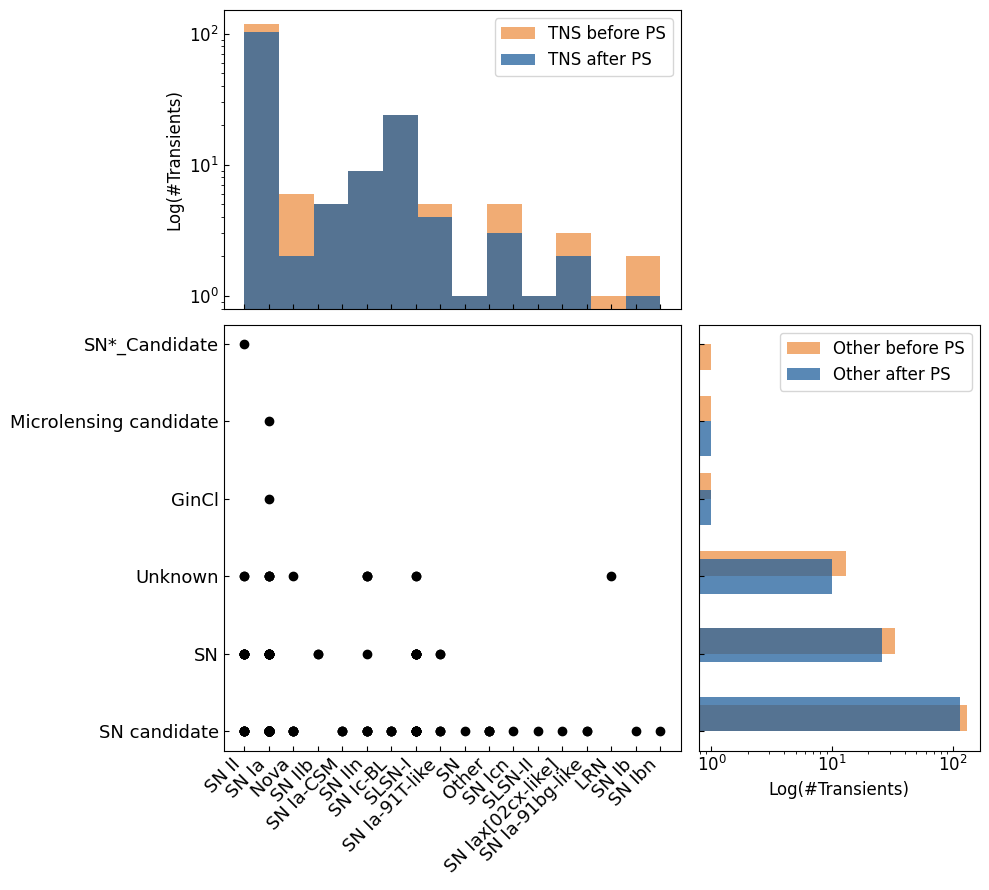

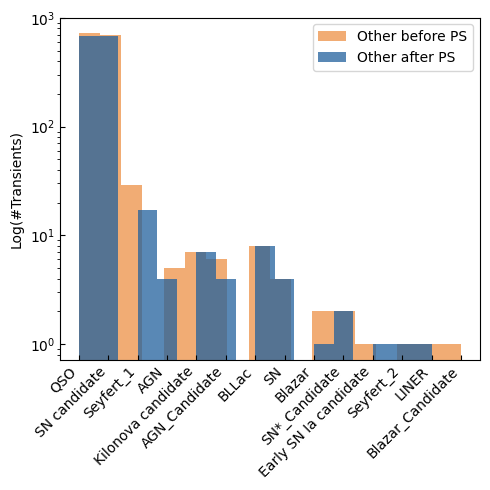

In [100]:
#STACKING DONE WITH THE BEST FWHM
#WE HAVE 3 BINS 1,2,3
#IF THERE IS ANYTHING BETWEEN 0,1 -> WE TAKE THAT
#OTHERWISE IF THERE IS ANYTHING BETWEEN 1,2 -> WE TAKE THAT
#OTHERWISE IF THERE IS ANYTHING BETWEEN 2,3 -> WE TAKE THAT
#the 'number of stamps in stacking is based on the fwhm bins'
#the decision of hostless/host is on the stacked image

# f,ax=plt.subplots(figsize=(4,4))
# plt.hist(monster_df['number_of_stamps_in_stacking'],log=True,bins='doane')
# #plt.axvline(np.median(monster_df['number_of_stamps_in_stacking']),color='k',alpha=0.5,ls='--')
# #plt.legend(loc='best')
# plt.ylabel('log(#Considered stamps)')
# plt.tick_params(axis='both',direction='in',labelsize=10)
# plt.savefig('number_of_stamps.pdf')
# plt.show()
# print(min(monster_df['number_of_stamps_in_stacking']))
# #NONE OF THESE WERE FOUND AS HOSTLESS
# print('Events with more than 200 stamps')
# print(monster_df[monster_df['number_of_stamps_in_stacking']>200][['objectId','number_of_stamps_in_stacking']])#,'v:tns_classification','v:classification']])
# events_with_many_stamps=list(monster_df[monster_df['number_of_stamps_in_stacking']>200]['objectId'])
# #print(events_with_many_stamps)
# print('='*25)
# print()
# #Events with only one stamp
# single_stamps = monster_df[monster_df['number_of_stamps_in_stacking']==1.0]
# single_stamps = single_stamps.reset_index(drop=True)

#Before PS analysis
#Histogram ofTNS classes
# fig,ax=plt.subplots()
# plt.hist(hostless_tns_class['v:tns_classification'])
# plt.xticks(rotation=45, ha='right')
# plt.show()
#Correlation TNS and machine learning classes
#plt.plot(hostless_tns_class['v:tns_classification'],hostless_tns_class['v:classification'],'ko')
#plt.xticks(rotation=45, ha='right')
#plt.figure(figsize=(12, 6))
fig = plt.figure(figsize=(10,9))
gs = GridSpec(4,4,width_ratios=[10,10,10,20],height_ratios=[25,20,1,12])
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])
ax_joint.plot(hostless_tns_class['unique_tns_class'],hostless_tns_class['unique_ml_class'],'ko')

ax_marg_x.hist(hostless_tns_class['unique_tns_class'],log=True,bins='doane',color=colors['orange'],alpha=0.75,label='TNS before PS')
ax_marg_x.hist(hostless_tns_class[(hostless_tns_class['ps_ks_template_15_statistic'] < 0.5) |
               (hostless_tns_class['ps_ks_science_15_statistic'] < 0.5)]['unique_tns_class'],log=True,
               bins='doane',color=colors['dark_blue'],alpha=0.75,label='TNS after PS')

ax_marg_y.hist(hostless_tns_class['unique_ml_class'],orientation="horizontal",log=True,bins='auto',color=colors['orange'],alpha=0.75,label='Other before PS')
ax_marg_y.hist(hostless_tns_class[(hostless_tns_class['ps_ks_template_15_statistic'] < 0.5) |
               (hostless_tns_class['ps_ks_science_15_statistic'] < 0.5)]['unique_ml_class'],
               orientation="horizontal",log=True,bins='auto',color=colors['dark_blue'],alpha=0.75,label='Other after PS')
# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)
# Set labels on marginals
ax_marg_y.set_xlabel('Log(#Transients)',fontsize=12)
ax_marg_x.set_ylabel('Log(#Transients)',fontsize=12)
ax_joint.set_xticks(ax_joint.get_xticks())
ax_joint.set_xticklabels(ax_joint.get_xticklabels(), rotation=45, ha='right')
ax_marg_y.tick_params(axis='both',direction='in',labelsize=12)
ax_marg_x.tick_params(axis='both',direction='in',labelsize=12)
ax_joint.tick_params(axis='both',direction='in',labelsize=13)
ax_marg_x.legend(loc=0,fontsize=12)
ax_marg_y.legend(loc=1,fontsize=12)
plt.tight_layout()
plt.savefig('TNSclass.pdf')
plt.show()


#Hostless candidates with ML classification
fig,ax=plt.subplots(figsize=(5,5))
plt.hist(hostless_ml_class['unique_ml_class'],log=True,bins='doane',alpha=0.75,color=colors['orange'],label='Other before PS')
plt.hist(hostless_ml_class[(hostless_ml_class['ps_ks_template_15_statistic'] < 0.5) |
         (hostless_ml_class['ps_ks_science_15_statistic'] < 0.5)]['unique_ml_class'],
         log=True,bins='doane',alpha=0.75,color=colors['dark_blue'],label='Other after PS')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Log(#Transients)')
plt.legend(loc='best')
plt.tick_params(axis='both',direction='in',labelsize=10)
plt.tight_layout()
plt.savefig('MLclass.pdf')
plt.show()

#print(hostless_ml_class.columns)
#print(hostless_ml_class[hostless_ml_class['v:classification']=='Kilonova candidate'][['objectId','ndethist']])
#print(hostless_ml_class[hostless_ml_class['v:classification']=='SN*_Candidate'][['objectId','ndethist']])
#ONLY OBJECT WITH HIGH PROBABILITY OF BEING A KILONOVA CANDIDATE
#ZTF23aambeqp
#Check if events with many stamps are found as hostless
# print('====================')
# for hmc in list(hostless_ml_class['objectId']):
#     if hmc in events_with_many_stamps:
#         print(hmc)
#pd.set_option('display.max_rows', 100)
#print(hostless_tns_class[['objectId','v:tns_classification','v:classification']])

# #print(hostless[['v:classification','v:tns_classification']])
# #print(np.unique(hostless['v:classification']))
# print('-------------')
# print('Total number of events: ',len(monster_df))
# print('Total number of events for which we consider a single stamp: ',len(single_stamps))
# print('Hostless candidates for which we consider a single stamp: ',len(single_stamps[single_stamps['is_hostless_candidate_clipping']==True]))
# print('Total number of hostless candidates: ',len(hostless))
# print('Number of hostless candidates with TNS classification: ',len(hostless_tns_class))
# print('Number of hostless candidates only with LC classification: ',len(hostless_ml_class))


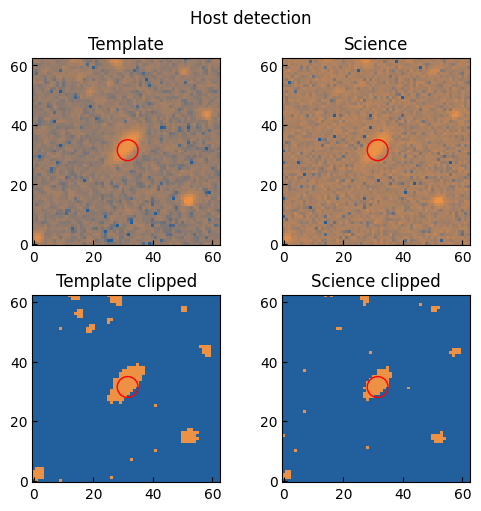

In [103]:
#Host example: https://fink-portal.org/ZTF23aaptfsu
fig,ax=plt.subplots(2,2,figsize=(5,5),layout='constrained')
circle1 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle2 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle3 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle4 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
for i in range(len(monster_df)):
    if monster_df["objectId"][i] == 'ZTF23aaptfsu':

        #Not clipped
        image_data0 = np.frombuffer(monster_df['b:cutoutTemplate_stampData_stacked'][i], dtype="float32").reshape(63, 63)
        image_data1 = np.frombuffer(monster_df['b:cutoutScience_stampData_stacked'][i], dtype="float32").reshape(63, 63)
        norm0 = simple_norm(image_data0, 'log', percent=99.)
        norm1 = simple_norm(image_data1, 'log', percent=99.)

        #Clipped
        #print(monster_df['template_clipped'][i])
        image_data2 = np.frombuffer(monster_df['template_clipped'][i], dtype="float64").reshape(63, 63)
        image_data3 = np.frombuffer(monster_df['science_clipped'][i], dtype="float64").reshape(63, 63)
        norm2 = simple_norm(image_data2, 'log', percent=99.)
        norm3 = simple_norm(image_data3, 'log', percent=99.)
                
        ax[0][0].imshow(image_data0, cmap=cmap,norm=norm0, origin='lower',interpolation='nearest')
        ax[0][1].imshow(image_data1, cmap=cmap,norm=norm1, origin='lower',interpolation='nearest')
        ax[0][0].set_title('Template')
        ax[0][1].set_title('Science')

        ax[1][0].imshow(image_data2, cmap=cmap,norm=norm2, origin='lower', interpolation='nearest')
        ax[1][1].imshow(image_data3, cmap=cmap,norm=norm3, origin='lower', interpolation='nearest')
        ax[1][0].set_title('Template clipped')
        ax[1][1].set_title('Science clipped')

        ax[0][0].add_patch(circle1)
        ax[0][1].add_patch(circle2)
        ax[1][0].add_patch(circle3)
        ax[1][1].add_patch(circle4)


ax[0][0].tick_params(axis='both',direction='in')
ax[0][1].tick_params(axis='both',direction='in')
ax[1][0].tick_params(axis='both',direction='in')
ax[1][1].tick_params(axis='both',direction='in')
plt.suptitle('Host detection')
plt.savefig('EG_success_host.pdf')
plt.show()
            

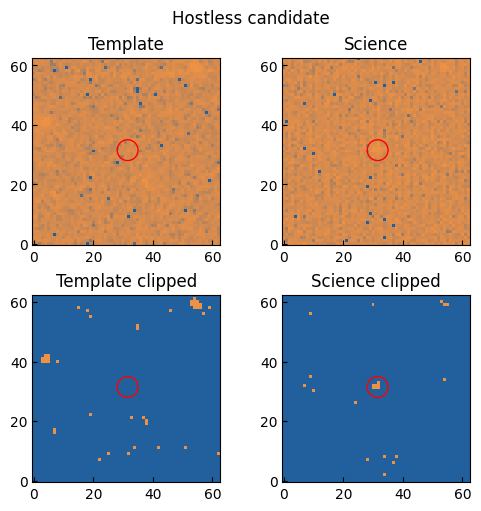

In [104]:
#No host example: https://fink-portal.org/ZTF23abbsfxp
fig,ax=plt.subplots(2,2,figsize=(5,5),layout='constrained')
circle1 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle2 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle3 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle4 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
for i in range(len(monster_df)):
    if monster_df["objectId"][i] == 'ZTF23abbsfxp':

        #Not clipped
        image_data0 = np.frombuffer(monster_df['b:cutoutTemplate_stampData_stacked'][i], dtype="float32").reshape(63, 63)
        image_data1 = np.frombuffer(monster_df['b:cutoutScience_stampData_stacked'][i], dtype="float32").reshape(63, 63)
        norm0 = simple_norm(image_data0, 'log', percent=99.)
        norm1 = simple_norm(image_data1, 'log', percent=99.)

        #Clipped
        #print(monster_df['template_clipped'][i])
        image_data2 = np.frombuffer(monster_df['template_clipped'][i], dtype="float64").reshape(63, 63)
        image_data3 = np.frombuffer(monster_df['science_clipped'][i], dtype="float64").reshape(63, 63)
        norm2 = simple_norm(image_data2, 'log', percent=99.)
        norm3 = simple_norm(image_data3, 'log', percent=99.)
                
        ax[0][0].imshow(image_data0, cmap=cmap,norm=norm0, origin='lower',interpolation='nearest')
        ax[0][1].imshow(image_data1, cmap=cmap,norm=norm1, origin='lower',interpolation='nearest')
        ax[0][0].set_title('Template')
        ax[0][1].set_title('Science')

        ax[1][0].imshow(image_data2, cmap=cmap,norm=norm2, origin='lower', interpolation='nearest')
        ax[1][1].imshow(image_data3, cmap=cmap,norm=norm3, origin='lower', interpolation='nearest')
        ax[1][0].set_title('Template clipped')
        ax[1][1].set_title('Science clipped')

        ax[0][0].add_patch(circle1)
        ax[0][1].add_patch(circle2)
        ax[1][0].add_patch(circle3)
        ax[1][1].add_patch(circle4)

ax[0][0].tick_params(axis='both',direction='in')
ax[0][1].tick_params(axis='both',direction='in')
ax[1][0].tick_params(axis='both',direction='in')
ax[1][1].tick_params(axis='both',direction='in')
plt.suptitle('Hostless candidate')
plt.savefig('EG_success_no_host.pdf')
plt.show()

/media3/CRP7/hosts/venv/hosts_env/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/media3/CRP7/hosts/venv/hosts_env/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


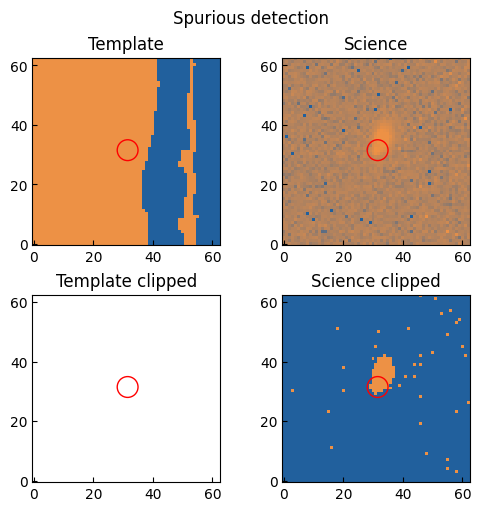

In [105]:
#No host bad detection example: https://fink-portal.org/ZTF22abbausm
fig,ax=plt.subplots(2,2,figsize=(5,5),layout='constrained')
circle1 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle2 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle3 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
circle4 = plt.Circle((31.5,31.5), 3.5, color='r', fill=False)
for i in range(len(monster_df)):
    if monster_df["objectId"][i] == 'ZTF22abbausm':

        #Not clipped
        image_data0 = np.frombuffer(monster_df['b:cutoutTemplate_stampData_stacked'][i], dtype="float32").reshape(63, 63)
        image_data1 = np.frombuffer(monster_df['b:cutoutScience_stampData_stacked'][i], dtype="float32").reshape(63, 63)
        norm0 = simple_norm(image_data0, 'log', percent=99.)
        norm1 = simple_norm(image_data1, 'log', percent=99.)

        #Clipped
        #print(monster_df['template_clipped'][i])
        image_data2 = np.frombuffer(monster_df['template_clipped'][i], dtype="float64").reshape(63, 63)
        image_data3 = np.frombuffer(monster_df['science_clipped'][i], dtype="float64").reshape(63, 63)
        norm2 = simple_norm(image_data2, 'log', percent=99.)
        norm3 = simple_norm(image_data3, 'log', percent=99.)
                
        ax[0][0].imshow(image_data0, cmap=cmap,norm=norm0, origin='lower',interpolation='nearest')
        ax[0][1].imshow(image_data1, cmap=cmap,norm=norm1, origin='lower',interpolation='nearest')
        ax[0][0].set_title('Template')
        ax[0][1].set_title('Science')

        ax[1][0].imshow(image_data2, cmap=cmap,norm=norm2, origin='lower', interpolation='nearest')
        ax[1][1].imshow(image_data3, cmap=cmap,norm=norm3, origin='lower', interpolation='nearest')
        ax[1][0].set_title('Template clipped')
        ax[1][1].set_title('Science clipped')

        ax[0][0].add_patch(circle1)
        ax[0][1].add_patch(circle2)
        ax[1][0].add_patch(circle3)
        ax[1][1].add_patch(circle4)

ax[0][0].tick_params(axis='both',direction='in')
ax[0][1].tick_params(axis='both',direction='in')
ax[1][0].tick_params(axis='both',direction='in')
ax[1][1].tick_params(axis='both',direction='in')
plt.suptitle('Spurious detection')
plt.savefig('EG_fail.pdf')
plt.show()

In [118]:
# #dfls[(dfls['roid']==2)|(dfls['roid']==3)]
# #np.where(dfls['objectId']=='ZTF23absbaum')
# #dfls.iloc[740]
# print(len(dfls))
# dfls=dfls[(dfls['roid']!=2)&(dfls['roid']!=3)]
# print(len(dfls))
# dfls=dfls[dfls['classtar']>=0.5]
# print(len(dfls))

In [25]:
# asteroids = []
# stars     = []
# all_last_stamps_and_stacked_result = pd.DataFrame()

# for i in range(len(last_stamps)):
#     dfls = pd.read_parquet(last_stamps[i])
#     dfls = dfls.reset_index(drop=True)

#     dfsr = pd.read_parquet(stacked_results[i])
#     dfsr = dfsr.reset_index(drop=True)

#     ls_plus_sr = pd.concat([dfls,dfsr],axis=1)
#     #select possible asteroids and keep objectId
#     possible_asteroids = ls_plus_sr[(ls_plus_sr['roid']==2)|(ls_plus_sr['roid']==3)]
#     possible_asteroids =  possible_asteroids.reset_index(drop=True)
#     if len(possible_asteroids) > 0:
#         #print(possible_asteroids)
#         for j in range(len(possible_asteroids)):
#             asteroids.append(possible_asteroids['objectId'][j])
#     #select possible stars and keep objectId
#     possible_stars = ls_plus_sr[ls_plus_sr['classtar']>=0.5]
#     possible_stars =  possible_asteroids.reset_index(drop=True)
#     if len(possible_stars) > 0:
#         #print(possible_asteroids)
#         for j in range(len(possible_stars)):
#             stars.append(possible_stars['objectId'][j])
    
#     #remove possible asteroids from final sample
#     ls_plus_sr = ls_plus_sr[(ls_plus_sr['roid']!=2)|(ls_plus_sr['roid']!=3)]
#     ls_plus_sr = ls_plus_sr.reset_index(drop=True)

#     #remove possible stars from final sample
#     ls_plus_sr = ls_plus_sr[ls_plus_sr['classtar']<0.5]
#     ls_plus_sr = ls_plus_sr.reset_index(drop=True)
    
#     all_last_stamps_and_stacked_result = pd.concat([all_last_stamps_and_stacked_result, ls_plus_sr])

In [83]:
#all considered objects over the two year period that have good stamps
all_events = []
for sr in stacked_results:
    dfsr = pd.read_parquet(sr)
    all_events.append(list(dfsr['objectID']))
all_events = sum(all_events,[])
len(all_events)

153536

In [84]:
print(len(events2y))
print(len(all_events))

155623
153536


In [85]:
#events that have bad stamps over the two years period
bad_stamps = []
for e in events2y:
    if e not in all_events:
        print(e)
        bad_stamps.append(e)

ZTF18aajqsgj
ZTF18adaqmzq
ZTF18adfllvd
ZTF20abggmbq
ZTF21aazeoxk
ZTF22aacqivs
ZTF22aaebcqs
ZTF22aafsksa
ZTF22aakpdjq
ZTF22aampzzv
ZTF22aboebji
ZTF23aadjoml
ZTF23aajogfq
ZTF23abrcher
ZTF23abtbklj
ZTF18aabpzhx
ZTF18aaqzgwh
ZTF19aamfqth
ZTF19aamowhb
ZTF19aanvehk
ZTF20aazylof
ZTF20actzwmz
ZTF21aapvspz
ZTF22aahnzcd
ZTF22aalgiky
ZTF22aalndni
ZTF22aamnajz
ZTF22aaqhibw
ZTF22aaymatf
ZTF22abbqakn
ZTF22abgcrso
ZTF23aaogbmd
ZTF23abuftum
ZTF20aaiyazr
ZTF21aaekepj
ZTF21aamcoii
ZTF21aamcyeo
ZTF21abbbbuo
ZTF22aaawsjq
ZTF22aacduwe
ZTF22aahzomm
ZTF22aaihjge
ZTF22aaiiwid
ZTF22aanlvbw
ZTF22aaodycs
ZTF23abqmkmu
ZTF23abtxuwp
ZTF18aagavez
ZTF18aaqlgfn
ZTF20abguuok
ZTF21aahwwbe
ZTF21acmqhbd
ZTF22aaiiocj
ZTF22aallece
ZTF22aalsffy
ZTF22abzixnq
ZTF23aajndeh
ZTF18aaecxkq
ZTF18aaiuopx
ZTF18ablczxo
ZTF19aaafewn
ZTF22aamhdwe
ZTF22aanacmy
ZTF23aaeqsvq
ZTF23aagagpf
ZTF23aajwskp
ZTF23aakrqjb
ZTF18aatwbtc
ZTF19aaprxow
ZTF21acdsnsh
ZTF21achsads
ZTF21acmhnpo
ZTF22abmjwcm
ZTF22abuqibf
ZTF23aaaxijj
ZTF23abshipt
ZTF23abtszlj

In [86]:
len(bad_stamps)

2087

In [ ]:
for image_data in stamps.iloc[indx][field_column[field]]: 
                field_data = fits.open(gzip.open(io.BytesIO(image_data)))
            field_data = field_data[0].data

In [81]:
# #Check objects with bad stamps
# c=0
# for of2y in origi_files2y:
#     if 'SUCCESS' not in of2y:
#         dfof2y = pd.read_parquet(parquet_files_list_path_2y+of2y)
#         for bs in bad_stamps:
#             #if bs in list(dfof2y['objectId']):
#             if bs == 'ZTF18aajqsgj':
#                 print(of2y)
#                 print(bs)
#                 idx = np.where(np.array(dfof2y['objectId']) == bs)[0][0]
#                 print(dfof2y.iloc[idx])
#                 if dfof2y['roid'][idx][0] == 0 or dfof2y['roid'][idx][0] == 1:
#                     if np.median(dfof2y['classtar'][idx]) < 0.50:
#                         c+=1
#                         print('In file: ',of2y)
#                         f,ax=plt.subplots(1,3)
#                         print(dfof2y['objectId'][idx])
#                         for img in dfof2y['b:cutoutScience_stampData'][idx]:
#                             image_data0 = fits.open(gzip.open(io.BytesIO(img)))
#                         image_data0 = image_data0[0].data
#                         for img in dfof2y['b:cutoutTemplate_stampData'][idx]:
#                             image_data1 = fits.open(gzip.open(io.BytesIO(img)))
#                         image_data1 = image_data1[0].data
#                         for img in dfof2y['b:cutoutDifference_stampData'][idx]:
#                             image_data2 = fits.open(gzip.open(io.BytesIO(img)))
#                         image_data2 = image_data2[0].data
#                         norm0 = simple_norm(image_data0, 'log', percent=99.)
#                         norm1 = simple_norm(image_data1, 'log', percent=99.)
#                         norm2 = simple_norm(image_data2, 'log', percent=99.)
#                         ax[0].imshow(image_data0,norm=norm0, origin='lower', interpolation='nearest')
#                         ax[1].imshow(image_data1,norm=norm1, origin='lower', interpolation='nearest')
#                         ax[2].imshow(image_data2,norm=norm2, origin='lower', interpolation='nearest')
#                         ax[0].set_title('Science')
#                         ax[1].set_title('Template')
#                         ax[2].set_title('Difference')
#                         plt.show()
# print(c)

NameError: name 'bad_stamps' is not defined

In [ ]:
ZTF18aajqsgj
ZTF18adaqmzq
ZTF18adfllvd
ZTF20abggmbq
ZTF21aazeoxk
ZTF22aacqivs
ZTF22aaebcqs
ZTF22aafsksa
ZTF22aakpdjq
ZTF22aampzzv
ZTF22aboebji
ZTF23aadjoml
ZTF23aajogfq
ZTF23abrcher
ZTF23abtbklj

In [7]:
#possible hostless events
possible_hostless_IDs = []
for sr in stacked_results:
    dfsr = pd.read_parquet(sr)
    possible_hostless_IDs.append(list(dfsr['objectID'][dfsr['is_hostless_candidate_clipping']]))
possible_hostless_IDs = sum(possible_hostless_IDs, [])

In [12]:
possible_hostless_IDs
with open("possible_hostless_IDs.txt", 'w') as f:
    for ph in possible_hostless_IDs:
        f.write(str(ph) + '\n')

In [25]:
# files_of_possible_hostless = []
# for of in norigi_files2y:
#     dfof = pd.read_parquet(parquet_files_list_path_2y+of)
#     for ph in possible_hostless_IDs:
#         if  ph in list(dfof['objectId']):
#             if of not in files_of_possible_hostless:
#                 files_of_possible_hostless.append(of)

In [13]:
with open("copy_possible_hostless_IDs.sh", 'w') as f:
    for fph in files_of_possible_hostless:
        f.write('cp '+str(fph)+' /media3/CRP7/hosts/misc_results/possible_hostless_sigma_clip/.' + '\n')

In [22]:
for sr in stacked_results:
    dfsr = pd.read_parquet(sr)
    for bs in bad_stamps:
        if bs in list(dfsr['objectID']):
            print(bs,sr)

In [27]:
for ls in last_stamps:
    dfls = pd.read_parquet(ls)
    print(dfls)
    print('======')
    for bs in bad_stamps:
        print(bs)
        print(list(dfls['objectId']))
        #input()
        if 'ZTF17aaajfhh' in list(dfls['objectId']):
            print('ENTRA===============')
            input()
            print(bs,ls)

        objectId                          b:cutoutScience_stampData  \
0   ZTF17aaajfhh  b'C4\xb9\xefC/\x85\xf2C2\xf0\xe8C7\xf0\xa7C3K"...   
1   ZTF17aabuoes  b'B\xfb\x11\xf0C\x0b?@B\xf3N\x18B\xfa\xad\x0cC...   
1   ZTF17aacnukn  b'B\xa7g\xe3B\xa4B\xbfB\xafW\xf1B\xa97\xdbB\xb...   
13  ZTF17aacqdmo  b'C4\xd9\xfeC>\x11\xd1C;\xcf\x90C=\x1b\xa6C5\x...   
0   ZTF18aaabyaz  b'C\x0e\x06\x88C\x1e\x0b_C\x16\x10/C\x1a\x1c\x...   
..           ...                                                ...   
0   ZTF23abtmyoq  b'B\xbd"JB\xcb\x95KB\xd2-\xd2B\xc3\xeb\xbbB\xc...   
0   ZTF23abudukq  b'DV\x03\xd0DUf\xd6D]h\xd6DZ\x82\xd0DUf\xbbDW\...   
0   ZTF23abueqfp  b'D\x0f\x08\x8aD\x11^QD\x11\xa1\xa7D\x15\x11\x...   
0   ZTF23abueuos  b'C\xa9\xfa C\xa9f\x8bC\x9f\x07{C\xa4\xba!C\xa...   
0   ZTF23abutziz  b'C\x8e\xa4TC\x8e\x96CC\x87m\xafC\x8d\xd8-C\x8...   

                           b:cutoutTemplate_stampData  \
0   b'C2\xe7\x8eC4\x1e\x8fC1\xfb\xd8C0N\xaaC/\xe9\...   
1   b'C\x034\xa5C\x027\xfbC\x03\x

KeyboardInterrupt: Interrupted by user

In [8]:
len(possible_hostless_IDs)

2580

In [20]:
df1 = pd.read_parquet('part-00025-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet')
df2 = pd.read_parquet('part-00025-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_last_stamp_df.parquet')
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)
# df2 = pd.read_parquet('part-00020-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet')
# df3 = pd.concat([df1,df2])
# print(len(df1))
# print(len(df2))
# print(len(df3))
print(df1['objectID'])
print(df2['objectId'])
print()
df3 = pd.concat([df2,df1],axis=1)
df3

0      ZTF17aaaehgf
1      ZTF17aaakhdz
2      ZTF17aadtngh
3      ZTF18aaadlhv
4      ZTF18aaapwah
           ...     
785    ZTF23abuexwd
786    ZTF23abufdfe
787    ZTF23abufdus
788    ZTF23abufuav
789    ZTF23abuhvqk
Name: objectID, Length: 790, dtype: object
0      ZTF17aaaehgf
1      ZTF17aaakhdz
2      ZTF17aadtngh
3      ZTF18aaadlhv
4      ZTF18aaapwah
           ...     
785    ZTF23abuexwd
786    ZTF23abufdfe
787    ZTF23abufdus
788    ZTF23abufuav
789    ZTF23abuhvqk
Name: objectId, Length: 790, dtype: object



,objectId,b:cutoutScience_stampData,b:cutoutTemplate_stampData,b:cutoutDifference_stampData,i:aimage,i:aimagerat,i:bimage,i:bimagerat,i:candid,i:chinr,...,objectID,b:cutoutScience_stampData_stacked,b:cutoutTemplate_stampData_stacked,b:cutoutDifference_stampData_stacked,science_clipped,template_clipped,number_of_stamps_in_stacking,is_hostless_candidate_clipping,distance_science,distance_template
0,ZTF17aaaehgf,b'B\xd4\x9a`B\xe0\xd5\x90B\xcdipB\xcdD\x80B\xe...,b'B\xe7\x1b\x83B\xe4\xd0\x89B\xe8N\x14B\xe7s\x...,b'@\xb7\x04\xf9@\xa9\x80\x9bA!\xaa\xd3Ad\x9b:\...,0.649,0.542631,0.592,0.494973,2309498783715010009,0.723,...,ZTF17aaaehgf,b'\xf0y\xf3B@$\xf3Bh\x02\xf0B\xc0\xae\xceB\xa0...,b'\xffo\xe6B\x89\xd0\xe4B\x14N\xe8B\x0es\xe7B:...,b'\\\xe2\x10\xc1\xed\xfaD\xc1aK\xc1\xc0k\x96\x...,b'\xf0y\xf3B@$\xf3Bh\x02\xf0B\xc0\xae\xceB\xa0...,b'\xffo\xe6B\x89\xd0\xe4B\x14N\xe8B\x0es\xe7B:...,3,False,0.0,0.0
1,ZTF17aaakhdz,b'B\xa4\xb2(B\x83J\xe0B\xa4$\x10B\xbc\xcc\xb8B...,b'B\xa3\x96\xb1B\xa2i\xc1B\x9dB\xb1B\x9f\xd2AB...,b'@\x04\xd9\x80AV\x90\x88@\x1c\x19T\xc1}u\xc0\...,0.672,0.557570,0.655,0.543464,2147170153715010002,0.842,...,ZTF17aaakhdz,b'(\xb2\xa4B\xe0J\x83B\x10$\xa4B\xb8\xcc\xbcB@...,b'\xb1\x96\xa3B\xc1i\xa2B\xb1B\x9dBA\xd2\x9fBX...,b'\x80\xd9\x04@\x88\x90VAT\x19\x1c@\xc0u}\xc1\...,b'(\xb2\xa4B\xe0J\x83B\x10$\xa4B\xb8\xcc\xbcB@...,b'\xb1\x96\xa3B\xc1i\xa2B\xb1B\x9dBA\xd2\x9fBX...,1,False,0.0,0.0
2,ZTF17aadtngh,"b'C,v\xb1C&\xf3VC\x1d?\xefC!1\xabC)\x01\xdfC%I...",b'C#\xa6nC!j\xeaC#\xc2eC%\x12DC!3\x08C!\xb2%C#...,b'\xc1\t1\xa3\xc0\xba\xb5w?\xdb\x923@\xb97\x81...,0.904,0.672634,0.626,0.465784,2152391284915010039,1.625,...,ZTF17aadtngh,b'q\x1d\x1dC\xe2\xe0!C\xef?\x1dC\xab1!C\x08\xb...,"b'y\xf0!C\xc3\x06 Cn\x8d""C\xcd\xff C\xe7\x92\x...",b'\xd7\x83\x92@w\xb5\xba\xc0\xde\x02\xb2?\x1c\...,b'q\x1d\x1dC\xe2\xe0!C\xef?\x1dC\xab1!C\x08\xb...,"b'y\xf0!C\xc3\x06 Cn\x8d""C\xcd\xff C\xe7\x92\x...",9,False,0.0,0.0
3,ZTF18aaadlhv,b'C.\xd5`C;>TC7\x1a\x14C?\x97\x88C1\xa0\x9cC8\...,b'C2\xddEC3\x1a\xc5C3?bC0w\x1eC0\x14SC/\xc0DC0...,b'?\xe3vG\xc0\x8co\xc9\xbf\xef\x13\x00\xc1\x7f...,0.485,0.408222,0.436,0.366979,2309175231715010003,0.489,...,ZTF18aaadlhv,b'`\xd5.CT>;C\x14\x1a7C\x88\x97?C\x9c\xa01C@\x...,b'E\xdd2C\xc5\x1a3Cb?3C\x1ew0CS\x140CD\xc0/C\x...,b'Gv\xe3?\xc9o\x8c\xc0\x00\x13\xef\xbf\x93q\x7...,b'`\xd5.CT>;C\x14\x1a7C\x88\x97?C\x9c\xa01C@\x...,b'E\xdd2C\xc5\x1a3Cb?3C\x1ew0CS\x140CD\xc0/C\x...,1,False,0.0,0.0
4,ZTF18aaapwah,b'Cg\xfc\xc8Cp\xe38C{IhC{u8Cy\xf1\x18C\x89o\xc...,b'C{\xf6\xd0C|\xb5KCy;@Cx@gCx\x18+CzB_Cz\xb5\x...,b'A\x97\xd9GA\x08y\xf6\xc0\xa0\xc6\xfd@\x15\x8...,0.845,0.497059,0.823,0.484118,1934341000015010025,0.499,...,ZTF18aaapwah,b'\xbe\x15\x1dC\x94\xef\x16C\xd2W\x1fC\x16R\x1...,b'>\x8d\x1cC\x1a[\x1dC\x91\xf8\x1cC\xf2-\x1eC\...,b'\x9e\xd4>\xc0\xd2\xa5&A\xbc%\x07\xc0\xc6~a?0...,b'\xbe\x15\x1dC\x94\xef\x16C\xd2W\x1fC\x16R\x1...,b'>\x8d\x1cC\x1a[\x1dC\x91\xf8\x1cC\xf2-\x1eC\...,10,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,ZTF23abuexwd,b'D\x1b\'0D\x1b\x03\x1cD$|\xc0D\x1c\xff\xf9D\x...,b'D\x19_GD\x1a\xbavD\x1bE\xa6D\x1a\x7fnD\x18\n...,b'\xc0U=?\xc0\xc8s\xb9\xc1\xe6-z\xc1\x80\r\x07...,0.987,0.346316,0.812,0.284912,2538483294015010034,0.772,...,ZTF23abuexwd,b'0\'\x1bD\x1c\x03\x1bD\xc0|$D\xf9\xff\x1cDK\x...,b'G_\x19Dv\xba\x1aD\xa6E\x1bDn\x7f\x1aD\xfc\n\...,b'?=U\xc0\xb9s\xc8\xc0z-\xe6\xc1\x07\r\x80\xc1...,b'0\'\x1bD\x1c\x03\x1bD\xecx\xad`\xf9\xff\x1cD...,b'G_\x19Dv\xba\x1aD\xa6E\x1bDn\x7f\x1aD\xfc\n\...,1,False,0.0,0.0
786,ZTF23abufdfe,b'C\xc9\xbe\xacC\xc9\xe7\xbfC\xcb\xd2mC\xc7\xf...,b'C\xcc\x86\x86C\xc8\xca\x91C\xc7\xf6aC\xc6OOC...,"b'@E\xfd\xae\xc0\xab\xeaB\xc1\x17\x8b\x9b\xc1,...",0.867,0.670811,0.771,0.596534,2538500101315010010,0.821,...,ZTF23abufdfe,b'\xac\xbe\xc9C\xbf\xe7\xc9Cm\xd2\xcbC\xe6\xff...,b'\x86\x86\xccC\x91\xca\xc8Ca\xf6\xc7COO\xc6C*...,"b'\xae\xfdE@B\xea\xab\xc0\x9b\x8b\x17\xc1""\x9f...",b'\xac\xbe\xc9C\xbf\xe7\xc9Cm\xd2\xcbC\xe6\xff...,b'\x86\x86\xccC\x91\xca\xc8Ca\xf6\

In [9]:
Monster_dataframe_stacked = []


['part-00025-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet',
 'part-00020-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet',
 'part-00034-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet',
 'part-00035-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet',
 'part-00196-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet',
 'part-00185-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet',
 'part-00015-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet',
 'part-00054-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet',
 'part-00155-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet',
 'part-00187-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet',
 'part-00181-83f0bd08-3548-4a5e-9111-7a4d1a883505-c000.snappy_stacked_results_df.parquet',

In [7]:
all_laststamps = pd.DataFrame()
for ls in last_stamps:
    dfls = pd.read_parquet(ls)
    dfls = dfls.reset_index(drop=True)
    all_laststamps = pd.concat([all_laststamps, dfls])

In [8]:
possible_hostless = all_laststamps[all_laststamps['objectId'].isin(possible_hostless_IDs)]
possible_hostless = possible_hostless.reset_index(drop=True)
possible_hostless.columns

Index(['objectId', 'b:cutoutScience_stampData', 'b:cutoutTemplate_stampData',
       'b:cutoutDifference_stampData', 'i:aimage', 'i:aimagerat', 'i:bimage',
       'i:bimagerat', 'i:candid', 'i:chinr', 'i:chipsf', 'i:classtar', 'i:dec',
       'i:fid', 'i:fwhm', 'i:isdiffpos', 'i:jd', 'i:maggaia',
       'i:maggaiabright', 'i:magpsf', 'i:neargaia', 'i:neargaiabright', 'i:ra',
       'i:sigmapsf', 'cdsxmatch', 'roid', 'mulens', 'snn_snia_vs_nonia',
       'snn_sn_vs_all', 'rf_snia_vs_nonia', 'ndethist', 'drb', 'classtar',
       'jd', 'jdstarthist', 'rf_kn_vs_nonkn', 'v:classification',
       'v:tns_classification', 'mangrove', 'gcvs', 'vsx', '3hsp', '4lac'],
      dtype='object')

In [9]:
possible_hostless.columns

Index(['objectId', 'b:cutoutScience_stampData', 'b:cutoutTemplate_stampData',
       'b:cutoutDifference_stampData', 'i:aimage', 'i:aimagerat', 'i:bimage',
       'i:bimagerat', 'i:candid', 'i:chinr', 'i:chipsf', 'i:classtar', 'i:dec',
       'i:fid', 'i:fwhm', 'i:isdiffpos', 'i:jd', 'i:maggaia',
       'i:maggaiabright', 'i:magpsf', 'i:neargaia', 'i:neargaiabright', 'i:ra',
       'i:sigmapsf', 'cdsxmatch', 'roid', 'mulens', 'snn_snia_vs_nonia',
       'snn_sn_vs_all', 'rf_snia_vs_nonia', 'ndethist', 'drb', 'classtar',
       'jd', 'jdstarthist', 'rf_kn_vs_nonkn', 'v:classification',
       'v:tns_classification', 'mangrove', 'gcvs', 'vsx', '3hsp', '4lac'],
      dtype='object')

In [10]:
np.where(possible_hostless['objectId']=='ZTF23aafamzc')

(array([54]),)

ZTF20aazqgdq QSO Unknown
ZTF23aafgthg QSO Unknown
ZTF19abhbvuw QSO Unknown
ZTF22aachlqv QSO Unknown
ZTF23aahrmkh SN candidate Unknown
ZTF20aalysyt QSO Unknown
ZTF23aagokui SN candidate Unknown
ZTF23aahrxrb SN candidate Unknown
ZTF23aaavigv QSO Unknown
ZTF18aclnxic QSO Unknown
ZTF19aaapfmv QSO Unknown
ZTF22aactvnj QSO Unknown
ZTF19adinajs QSO Unknown
ZTF18adlqyxx QSO Unknown
ZTF20aaerpur QSO Unknown
ZTF18aawyesh QSO Unknown
ZTF19acmvzdd QSO Unknown
ZTF21aalxxvm QSO Unknown
ZTF20aannqcc QSO Unknown
ZTF21aasvhth QSO Unknown
ZTF20aajwdyx QSO Unknown
ZTF20adctuzr QSO Unknown
ZTF19aagrbrd Seyfert_1 Unknown
ZTF23aacvjpo SN candidate Unknown
ZTF19aasbwdd QSO Unknown
ZTF18aaozjap QSO Unknown
ZTF21aaiodij QSO Unknown
ZTF23aaecsyd SN candidate Unknown
ZTF22abftrnr QSO Unknown
ZTF22aahwvos QSO Unknown
ZTF23aafwpuy SN candidate Unknown
ZTF23aahpegd SN candidate Unknown
ZTF23aairfkw SN candidate Unknown
ZTF18aagrcbh QSO Unknown
ZTF18aaxnjew Seyfert_1 Unknown
ZTF18aaznhlr QSO Unknown
ZTF19aakixrl QSO

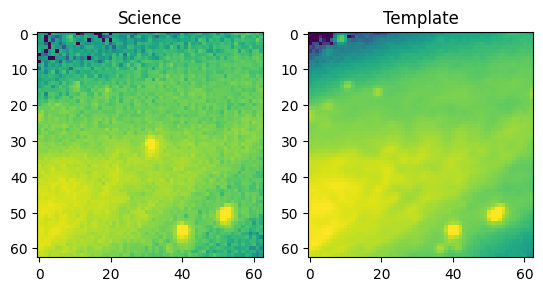

ZTF23aaeyukj SN candidate Unknown
ZTF23aafvjmu SN candidate Unknown
ZTF23aahpeyb SN candidate Unknown
ZTF23aahoegs SN candidate Unknown
ZTF23aagaqgn QSO Unknown
ZTF18acuskbg QSO Unknown
ZTF23aaeprgf SN candidate Unknown
ZTF20acmgidi QSO Unknown
ZTF23aafggjj SN candidate (TNS) SN Ia
ZTF21aasrmgv QSO Unknown
ZTF23aafamzc SN candidate Unknown
ZTF18aajsghk QSO Unknown
ZTF20aagvkuq QSO Unknown
ZTF19aasbgti QSO Unknown
ZTF21abaevio QSO Unknown
ZTF23aadctoq SN candidate Unknown
ZTF22aadtadp QSO Unknown
ZTF23aabtgej SN candidate (TNS) SN Ia
ZTF23aabrkaf SN candidate Unknown
ZTF23aaeqtbr SN candidate Unknown
ZTF23aaeiypm SN candidate Unknown
ZTF23aagxpnv SN candidate Unknown
ZTF19adgmpkx QSO Unknown
ZTF20aazglbq QSO Unknown
ZTF21aairzmf QSO Unknown
ZTF18abcyujq QSO Unknown
ZTF18abatcmy Seyfert_1 Unknown
ZTF23aagaiwh SN candidate Unknown
ZTF23aagiaiw SN candidate Unknown
ZTF23aabkpga QSO Unknown
ZTF23aaekwih SN candidate Unknown
ZTF19aartgnx QSO Unknown
ZTF21aagtrks QSO Unknown
ZTF23aaazegi SN c

In [14]:
#We only have prob SN >= 50% and we shouldn't have ambiguous things
for i in range(len(possible_hostless)):
    print(possible_hostless["objectId"][i],possible_hostless['v:classification'][i], possible_hostless['v:tns_classification'][i])
    try:
        if possible_hostless["objectId"][i] == 'ZTF23aadvjqb':
        #if possible_hostless["objectId"][i] == 'ZTF23aaecsyd':
        #if possible_hostless["objectId"][i] == 'ZTF23aaeprgf':
            image_data0 = np.array(xmatch_tns[columns[i]].values[indx])
            image_data1 = 
            image_data2 = 
            norm0 = simple_norm(image_data0, 'log', percent=99.)
            norm1 = simple_norm(image_data1, 'log', percent=99.)
            norm2 = simple_norm(image_data2, 'log', percent=99.)
            #ax.imow(datasci.astype(float),norm=norm, origin='lower', interpolation='nearest')
                
            fig,ax=plt.subplots(1,2)
            ax[0].imshow(image_data0,norm=norm0, interpolation='nearest')
            ax[1].imshow(image_data1,norm=norm1, interpolation='nearest')
            #ax[2].imshow(image_data2,norm=norm2, interpolation='nearest')
            ax[0].set_title('Science')
            ax[1].set_title('Template')
            #ax[2].set_title('Difference')
            plt.show()
            
    except:
        print('Failure')

In [18]:
print(possible_hostless['v:tns_classification'][possible_hostless['v:tns_classification']!='Unknown'])

43         (TNS) SN Ib
52         (TNS) SN Ia
61         (TNS) SN Ia
77     (TNS) SN Ia-CSM
83        (TNS) SN IIn
93     (TNS) SN Ia-CSM
99         (TNS) SN Ia
129        (TNS) SN Ia
150       (TNS) SLSN-I
173        (TNS) SN Ia
192        (TNS) SN Ia
Name: v:tns_classification, dtype: object


In [11]:
#ZTF23aabrkaf
#np.where(['objectID']=='ZTF23aafamzc')

all_stacked = pd.DataFrame()
for sr in stacked_results:
    dfsr = pd.read_parquet(sr)
    dfsr = dfsr.reset_index(drop=True)
    all_stacked = pd.concat([all_stacked, dfsr])

In [12]:
all_stacked = all_stacked.reset_index(drop=True)
np.where(all_stacked['objectID']=='ZTF23aafamzc')

(array([28393]),)

In [13]:
image_data0 = _read_bytes_image(possible_hostless['b:cutoutScience_stampData'][0])
plt.imshow(image_data0)

OSError: Empty or corrupt FITS file

In [24]:
np.unique(np.array(classes_S))

array(['AGN_Candidate', 'Early SN Ia candidate', 'LINER', 'QSO',
       'SN candidate', 'Seyfert_1', 'Unknown'], dtype='<U21')

In [25]:
np.unique(np.array(classes_TNS))

array(['(TNS) SLSN-I', '(TNS) SN IIn', '(TNS) SN Ia', '(TNS) SN Ia-CSM',
       '(TNS) SN Ib', 'Unknown'], dtype='<U15')

In [21]:
df=pd.read_csv('part-00189-0c75b8f5-673a-427d-9ba4-2f54583a447b-c000.snappy.stacked_results_df.csv')
#171
#df.columns
#type(df['b:cutoutScience_stampData_last'][171])

#data = np.array(df['b:cutoutScience_stampData_last'][171])
#norm = simple_norm(data.astype(float), 'log', percent=99.)

#science_stamp = (df['b:cutoutScience_stampData_last'][171].apply(_read_bytes_image))

#print(science_stamp)
hdu_list = fits.open(gzip.open(io.BytesIO(df['b:cutoutScience_stampData_last'][171])))

TypeError: a bytes-like object is required, not 'str'